In [26]:
# Importing data and doing train/val split...

import pandas as pd
from sklearn.model_selection import train_test_split

LOCAL = '../data/tanzania/'

train = pd.merge(pd.read_csv(LOCAL + 'train_features.csv'),
                 pd.read_csv(LOCAL + 'train_labels.csv'))
test = pd.read_csv(LOCAL + 'test_features.csv')
sample_submission = pd.read_csv(LOCAL + 'sample_submission.csv')

train, val = train_test_split(
    train, train_size=0.80, test_size=0.20, 
    stratify=train['status_group'], random_state=42)

In [27]:
# Wrangling data...

import numpy as np

def wrangle(data):
    """Wrangles train, validate, and test sets in the same way"""
    data = data.copy()
    
    # When latitude has small values near zero outside Tanzania, 
    # treating these values like zero...
    data['latitude'] = data['latitude'].replace(-2e-08, 0)
        
    # Replacing zeros used to represent nulls with actual nulls...
    cols_with_zeros = ['construction_year',
                       'longitude',
                       'latitude',
                       'gps_height',
                      ]
    for col in cols_with_zeros:
        data[col] = data[col].replace(0, np.nan)
        data[col] = data[col].fillna(data[col].mean())
    
    # Converting date_recorded to datetime format...
    data['date_recorded'] = pd.to_datetime(data['date_recorded'], 
                                           infer_datetime_format=True)
    
    # Creating year_recorded from date_recorded...
    data['year_recorded'] = data['date_recorded'].dt.year
    # Creating month_recorded from date_recorded...
    data['month_recorded'] = data['date_recorded'].dt.month
    
    # Engineering years_since_construction
    data['years_since_construction'] = data[
        'year_recorded'] - data['construction_year']

    # Encoding boolean features as ordinals...
    cols_with_bools = ['public_meeting',
                       'permit']
    for col in cols_with_bools:
        data[col] = data[col].replace({True: 1, False: 0})
        # Filling NaNs with mean, though not a perfect solution with bools...
        data[col] = data[col].fillna(data[col].mean())
    
    # Handling NaNs in scheme_management...
    data['scheme_management'] = data['scheme_management'].fillna('MISSING')

    # Simplifying water_quality...
    data['water_quality'] = data['water_quality'].replace(
        'fluoride abandoned', 'fluoride')
    
    # Simplifying extraction_type...
    data['extraction_type'] = data['extraction_type'].replace(
        'ksb', 'submersible')    
    data['extraction_type'] = data['extraction_type'].replace(
        ['other - swn 81', 'walimi'], 'other handpump')    
    data['extraction_type'] = data['extraction_type'].replace(
        ['other - play pump', 'other - mkulima/shinyanga', 'climax'],
        'other')

    # Dropping columns...
    cols_to_drop = ['recorded_by', # only has one value
                    'quantity_group', # duplicate of quantity
                    'num_private', # virtually all zeros
                    'payment_type', # essentially a duplicate of payment
                    'quality_group', # see modified water_quality
                    'waterpoint_type_group', # see waterpoint_type
                    'management_group', # see management
                    'source_type', # see source
                    'source_class', # see source
                    'extraction_type_group', # see modified extraction_type
                    'extraction_type_class', # see modified extraction_type
                    'region_code', # see region
                    'district_code', # does not pick out contiguous regions
                    'subvillage', # see longitude and latitude, plus lga
                    'ward', # see longitude and latitude, plus lga
                    'scheme_name', # see scheme_management
                    'date_recorded', # see year_recorded and month_recorded
                    'wpt_name', # names of waterpoints are individualized
                   ]
    for col in cols_to_drop:
        data = data.drop(columns=col)
    
    return data

train = wrangle(train)
val = wrangle(val)
test = wrangle(test)


Train Accuracy Score: 0.9423821548821549
Validation Accuracy Score: 0.8170875420875421


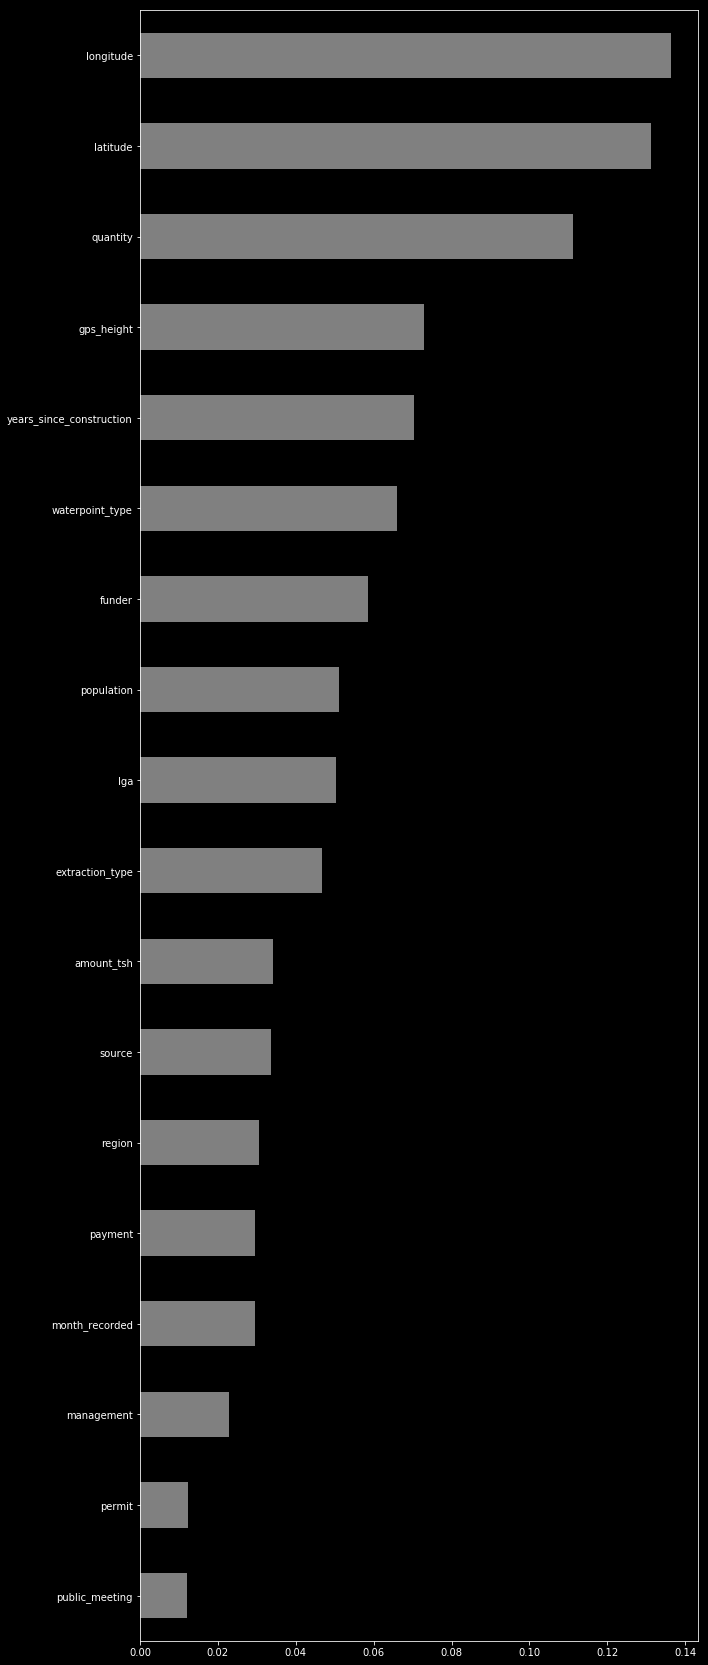

In [830]:
# Using a random forest classifier with ordinal encoding...

import category_encoders as ce
from sklearn.preprocessing import RobustScaler
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt

target = 'status_group'

# Including high cardinality categorical features...
# Dropped 'installer', 'year_recorded', & 'water_quality' after experiment...
features = train.drop(columns=[target,
                               'id',
                               'installer',
                               'year_recorded',
                               'water_quality',
                               'scheme_management',
                               'basin',
                               'construction_year',
                              ]).columns.tolist()

# Arranging data into X features matrix and y target vector...
X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]
X_test = test[features]

# Ordinal encoding categorical features...
encoder = ce.OrdinalEncoder()
X_train_encoded = encoder.fit_transform(X_train)
X_val_encoded = encoder.transform(X_val)
X_test_encoded = encoder.transform(X_test)

# Scaling data with robust scaler...
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train_encoded)
X_val_scaled = scaler.transform(X_val_encoded)
X_test_scaled = scaler.transform(X_test_encoded)

# Fitting model on train data...
model = RandomForestClassifier(n_estimators=100, # 100 works well
                               criterion='entropy', # entropy seems optimal
                               max_depth=22, # 18 to 23 seems optimal
                               min_samples_split=4, # 4 to 6 seems optimal
                               min_samples_leaf=1, # default 1 seems optimal
                               min_weight_fraction_leaf=.00001, # .00001 good
                               max_features=4, # 3 to 4 seems optimal
                               max_leaf_nodes=5000, # 5000 is good
                               min_impurity_decrease=.00000001, # 10-6 to 10-8
                               bootstrap=True, # default True seems optimal
                               oob_score=True, # True seems optimal
                               n_jobs=-1, # -1 seems optimal
                               warm_start=False, # default False seems optimal
                               class_weight=None) # default None seems optimal
model.fit(X_train_scaled, y_train)

# Scoring accuracy, predicting on test data...
print('\nTrain Accuracy Score:', model.score(X_train_scaled, y_train))
print('Validation Accuracy Score:', model.score(X_val_scaled, y_val))
y_pred = model.predict(X_test_scaled)

# Plotting coefficients...
coefficients = pd.Series(model.feature_importances_,
                         X_train_encoded.columns.tolist())
plt.style.use('dark_background')
plt.figure(figsize=(10,30))
coefficients.sort_values().plot.barh(color='grey');

In [816]:
# Now let's try RandomizedSearchCV for hyperparameter tuning...

from scipy.stats import randint as sp_randint
from scipy.stats import uniform
from sklearn.model_selection import RandomizedSearchCV

target = 'status_group'

# Including high cardinality categorical features...
# Dropped 'installer', 'year_recorded', & 'water_quality' after experiment...
features = train.drop(columns=[target,
                               'id',
                               'installer',
                               'year_recorded',
                               'water_quality',
                               'scheme_management',
                               'basin',
                               'construction_year',
                              ]).columns.tolist()

# Arranging data into X features matrix and y target vector...
X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]
X_test = test[features]

# Ordinal encoding categorical features...
encoder = ce.OrdinalEncoder()
X_train_encoded = encoder.fit_transform(X_train)
X_val_encoded = encoder.transform(X_val)
X_test_encoded = encoder.transform(X_test)

# Scaling data with robust scaler...
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train_encoded)
X_val_scaled = scaler.transform(X_val_encoded)
X_test_scaled = scaler.transform(X_test_encoded)

# Specifying model for hyperparameter tuning...
clf = RandomForestClassifier(n_estimators=100)

# Specifying parameters and distributions to sample from...
param_dist = {'criterion': ['gini', 'entropy'],
              'max_depth': sp_randint(15, 30),
              'min_samples_split': sp_randint(2, 8),
              'min_samples_leaf': sp_randint(1, 4),
              'min_weight_fraction_leaf': uniform(.000001, .0001),
              'max_features': sp_randint(2, 6),
              'max_leaf_nodes': sp_randint(1000, 10000),
              'min_impurity_decrease': uniform(.000000001, .0000001),
              'oob_score': [True, False],
              }

# Running randomized search...
random_search = RandomizedSearchCV(clf, param_distributions=param_dist,
                                   n_iter=10, cv=5, iid=False)

# Fitting model to train data...
random_search.fit(X_train_scaled, y_train)

# Scoring accuracy, predicting on test data...
print('\nTrain Accuracy Score:', random_search.score(X_train_scaled, y_train))
print('Validation Accuracy Score:', random_search.score(X_val_scaled, y_val))
y_pred = random_search.predict(X_test_scaled)

# Not as good as manual hyperparameter tuning!


Train Accuracy Score: 0.9113425925925925
Validation Accuracy Score: 0.8104377104377104


In [831]:
submission = sample_submission.copy()
submission['status_group'] = y_pred
submission.to_csv('nathan_van_wyck_submission.csv', index=False)